In [1]:
# import 
import pandas as pd
import numpy as np
from scipy import interpolate

import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.cm as cm
import seaborn as sns

import os, glob, joblib
from datetime import datetime
import re

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score ,roc_curve, recall_score, precision_score, f1_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# SK colormap
sk_red = '#EA002C'
sk_orange = '#F47725'
sk_teal = '#009A93'
sk_blue = '#0072C6'

---
## KLARF file parsing

In [3]:
dir_path = "./klarfsample_v2"
file_path = os.path.join(dir_path, '*.001')
path_list = glob.glob(file_path)

len(path_list)

210

In [4]:
# 실행할 때마다 한 줄씩 읽어오기
# readlines()로 한번에 시도하면, 용량이 큰 파일의 경우엔 out of memory 가능성.

def readfile(file_path):
    readlines = []
    with open(file_path, 'r') as f:
        i = 1
        while True:
            line = f.readline()
            if not line:
                break
            if line[0] == ' ':
                line = line.strip(' ')
            line = str(i) + ' ' + line
            readlines.append(line.strip('\n').strip(';').split(' '))
            i += 1    
    return readlines

readfile(path_list[0])

[['1', 'FileVersion', '1', '1'],
 ['2', 'FileTimestamp', '12-18-22', '19:29:00'],
 ['3', 'TiffSpec', '6.0', 'G', 'R'],
 ['4',
  'InspectionStationID',
  '"ADVANCED',
  'TECHNOLOGY',
  'INC"',
  '"M08AWD10"',
  '"M08AWD10"'],
 ['5', 'SampleType', 'WAFER'],
 ['6', 'ResultTimestamp', '12-18-22', '19:28:59'],
 ['7', 'LotID', '"KMIB086T"'],
 ['8', 'SampleSize', '1', '300'],
 ['9', 'DeviceID', '"KMIB086T"'],
 ['10', 'SetupID', '"MI_MONITORING"', '12-18-22', '19:28:59'],
 ['11', 'StepID', '"MI_MONITORING"'],
 ['12', 'SampleOrientationMarkType', 'NOTCH'],
 ['13', 'OrientationMarkLocation', 'DOWN'],
 ['14', 'TiffFilename', 'MI_MONITORING_KMIB086T_00-01.tif'],
 ['15', 'DiePitch', '1.196068e+004', '7.820596e+003'],
 ['16', 'DieOrigin', '0.000000e+000', '0.000000e+000'],
 ['17', 'WaferID', '"01"'],
 ['18', 'Slot', '01'],
 ['19', 'SampleCenterLocation', '1.196068e+004', '7.820596e+003'],
 ['20', 'InspectionTest', '1'],
 ['21', 'SampleTestPlan', '667'],
 ['22', '-2', '18'],
 ['23', '-1', '18'],
 ['2

### KLARF file의 설비, 제품 및 시간에 대한 데이터 parsing

In [5]:
# KLARF file로부터 데이터 parsing
temp_df = pd.DataFrame()
fname = []
for i, fp in enumerate(path_list):
    dict_klarf = {}
    for line in readfile(fp):
        if not line[1].lstrip('-').isnumeric():
            dict_klarf[line[1]] = ' '.join(line[2:])
    fname.append(os.path.splitext(os.path.basename(fp))[0])
    temp = pd.DataFrame(dict_klarf, index=[i])
    temp_df = pd.concat([temp_df, temp])

temp_df.columns = temp_df.columns.str.lower()
temp_df['filename'] = fname
cols = ['filename']
cols.extend(temp_df.columns[:-1])

temp_df = temp_df[cols]
temp_df.head(3)

,filename,fileversion,filetimestamp,tiffspec,inspectionstationid,sampletype,resulttimestamp,lotid,samplesize,deviceid,...,slot,samplecenterlocation,inspectiontest,sampletestplan,areapertest,defectrecordspec,defectlist,summaryspec,summarylist,endoffile
0,MI_MONITORING_KMIB086T_00-01,1 1,12-18-22 19:29:00,6.0 G R,"""ADVANCED TECHNOLOGY INC"" ""M08AWD10"" ""M08AWD10""",WAFER,12-18-22 19:28:59,"""KMIB086T""",1 300,"""KMIB086T""",...,01,1.196068e+004 7.820596e+003,1,667,6.239095e+010,17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZ...,,5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE,,
1,TAGM_REFLOW_INSP3_TAGHB30TA_00-01,1 1,12-07-22 15:55:41,6.0 G R,"""ADVANCED TECHNOLOGY INC"" ""M08AWD10"" ""M08AWD10""",WAFER,12-07-22 15:55:40,"""TAGHB30TA""",1 300,"""TAGHB30TA""",...,01,3.724062e+003 7.144190e+003,1,929,4.943285e+010,17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZ...,,5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE,,
2,TAGM_REFLOW_INSP3_TAGHB30TA_00-10,1 1,12-07-22 16:02:55,6.0 G R,"""ADVANCED TECHNOLOGY INC"" ""M08AWD10"" ""M08AWD10""",WAFER,12-07-22 16:02:52,"""TAGHB30TA""",1 300,"""TAGHB30TA""",...,10,3.724062e+003 7.144190e+003,1,884,4.703836e+010,17 DEFECTID XREL YREL XINDEX YINDEX XSIZE YSIZ...,,5 TESTNO NDEFECT DEFDENSITY NDIE NDEFDIE,,


In [6]:
selectCols = [
    "filename",
    "inspectionstationid",
    "resulttimestamp",
    "lotid",
    "deviceid",
    "setupid",
    "stepid",
    ]
# 특정 columns만 추출
temp_df = temp_df[selectCols]

In [7]:
# column 비교 후 제거 함수
# 보존할 column = col1
# 제거할 column = col2
def eliminate(df, col1, col2):
    '''
    col1: 남길 컬럼
    col2: 제거할 컬럼
    '''
    if df[df[col1] != df[col2]].size == 0:
        df.drop(columns=col2, inplace=True)
        print(f'"{col2}" Column 제거됨.')
    return df

In [8]:
# temp_df의 FileTimestamp를 datetime형으로 변환
# 현재 %m-%d-%y %H:%M:%S 형태로 되어있음. 이를 %Y-%m-%d %H:%M:%S

temp_df.resulttimestamp = temp_df.resulttimestamp.apply(lambda x: datetime.strptime(x, "%m-%d-%y %H:%M:%S"))
temp_df.head(3)

,filename,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid
0,MI_MONITORING_KMIB086T_00-01,"""ADVANCED TECHNOLOGY INC"" ""M08AWD10"" ""M08AWD10""",2022-12-18 19:28:59,"""KMIB086T""","""KMIB086T""","""MI_MONITORING"" 12-18-22 19:28:59","""MI_MONITORING"""
1,TAGM_REFLOW_INSP3_TAGHB30TA_00-01,"""ADVANCED TECHNOLOGY INC"" ""M08AWD10"" ""M08AWD10""",2022-12-07 15:55:40,"""TAGHB30TA""","""TAGHB30TA""","""TAGM_REFLOW_INSP3"" 12-07-22 15:55:40","""WAFER REFLOW INSP3"""
2,TAGM_REFLOW_INSP3_TAGHB30TA_00-10,"""ADVANCED TECHNOLOGY INC"" ""M08AWD10"" ""M08AWD10""",2022-12-07 16:02:52,"""TAGHB30TA""","""TAGHB30TA""","""TAGM_REFLOW_INSP3"" 12-07-22 16:02:52","""WAFER REFLOW INSP3"""


In [9]:
# InspectionStationID column
print(temp_df.inspectionstationid.unique())

temp_df.inspectionstationid = temp_df.inspectionstationid.apply(lambda x: ' '.join(x.strip('"').split('" "')[1:])\
    if x.strip('"').split('" "')[1] != x.strip('"').split('" "')[2] \
        else x.strip('"').split('" "')[-1])
temp_df.head(3)

['"ADVANCED TECHNOLOGY INC" "M08AWD10" "M08AWD10"']


,filename,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid
0,MI_MONITORING_KMIB086T_00-01,M08AWD10,2022-12-18 19:28:59,"""KMIB086T""","""KMIB086T""","""MI_MONITORING"" 12-18-22 19:28:59","""MI_MONITORING"""
1,TAGM_REFLOW_INSP3_TAGHB30TA_00-01,M08AWD10,2022-12-07 15:55:40,"""TAGHB30TA""","""TAGHB30TA""","""TAGM_REFLOW_INSP3"" 12-07-22 15:55:40","""WAFER REFLOW INSP3"""
2,TAGM_REFLOW_INSP3_TAGHB30TA_00-10,M08AWD10,2022-12-07 16:02:52,"""TAGHB30TA""","""TAGHB30TA""","""TAGM_REFLOW_INSP3"" 12-07-22 16:02:52","""WAFER REFLOW INSP3"""


In [10]:
# # "LotID", "DeviceID", "StepID", "WaferID" columns에 대해 " " 제거
# temp_df[["LotID", "DeviceID", "StepID", "WaferID"]] = \
#     temp_df[["LotID", "DeviceID", "StepID", "WaferID"]].applymap(lambda x: x.strip(' "'))
# temp_df.head(3)
# 모든 columns에 대해 (") 제거
temp_df[["setupid", "lotid", "deviceid", "stepid"]] = \
    temp_df[["setupid", "lotid", "deviceid", "stepid"]].applymap(lambda x: x.replace('"',''))
temp_df.head(3)

,filename,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid
0,MI_MONITORING_KMIB086T_00-01,M08AWD10,2022-12-18 19:28:59,KMIB086T,KMIB086T,MI_MONITORING 12-18-22 19:28:59,MI_MONITORING
1,TAGM_REFLOW_INSP3_TAGHB30TA_00-01,M08AWD10,2022-12-07 15:55:40,TAGHB30TA,TAGHB30TA,TAGM_REFLOW_INSP3 12-07-22 15:55:40,WAFER REFLOW INSP3
2,TAGM_REFLOW_INSP3_TAGHB30TA_00-10,M08AWD10,2022-12-07 16:02:52,TAGHB30TA,TAGHB30TA,TAGM_REFLOW_INSP3 12-07-22 16:02:52,WAFER REFLOW INSP3


In [11]:
# SetupID column에서 timestamp가 FileTimestamp와 일치하는지 확인.
# 완벽히 일치한다면 해당 timestamp만 제거.
if temp_df[temp_df.setupid.apply(lambda x: datetime.strptime(' '.join(x.split(" ")[1:]).strip(' '), "%m-%d-%y %H:%M:%S"))
        != temp_df.resulttimestamp].size == 0:
    temp_df.setupid = temp_df.setupid.apply(lambda x: x.split(" ")[0])
    print('timestamp 제거됨.')
temp_df.head(3)

timestamp 제거됨.


,filename,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid
0,MI_MONITORING_KMIB086T_00-01,M08AWD10,2022-12-18 19:28:59,KMIB086T,KMIB086T,MI_MONITORING,MI_MONITORING
1,TAGM_REFLOW_INSP3_TAGHB30TA_00-01,M08AWD10,2022-12-07 15:55:40,TAGHB30TA,TAGHB30TA,TAGM_REFLOW_INSP3,WAFER REFLOW INSP3
2,TAGM_REFLOW_INSP3_TAGHB30TA_00-10,M08AWD10,2022-12-07 16:02:52,TAGHB30TA,TAGHB30TA,TAGM_REFLOW_INSP3,WAFER REFLOW INSP3


In [12]:
# 수정된 SetupID column에서 Metrology-Type이 StepID와 일치하는지 확인.
# 완벽히 일치한다면 해당 column 제거.
temp_df = eliminate(temp_df, 'stepid', 'setupid')
temp_df.head(3)

,filename,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid
0,MI_MONITORING_KMIB086T_00-01,M08AWD10,2022-12-18 19:28:59,KMIB086T,KMIB086T,MI_MONITORING,MI_MONITORING
1,TAGM_REFLOW_INSP3_TAGHB30TA_00-01,M08AWD10,2022-12-07 15:55:40,TAGHB30TA,TAGHB30TA,TAGM_REFLOW_INSP3,WAFER REFLOW INSP3
2,TAGM_REFLOW_INSP3_TAGHB30TA_00-10,M08AWD10,2022-12-07 16:02:52,TAGHB30TA,TAGHB30TA,TAGM_REFLOW_INSP3,WAFER REFLOW INSP3


In [13]:
# StepID의 column 통일
temp_df.stepid = temp_df.stepid.apply(lambda x: x.upper())
temp_df.head(3)

,filename,inspectionstationid,resulttimestamp,lotid,deviceid,setupid,stepid
0,MI_MONITORING_KMIB086T_00-01,M08AWD10,2022-12-18 19:28:59,KMIB086T,KMIB086T,MI_MONITORING,MI_MONITORING
1,TAGM_REFLOW_INSP3_TAGHB30TA_00-01,M08AWD10,2022-12-07 15:55:40,TAGHB30TA,TAGHB30TA,TAGM_REFLOW_INSP3,WAFER REFLOW INSP3
2,TAGM_REFLOW_INSP3_TAGHB30TA_00-10,M08AWD10,2022-12-07 16:02:52,TAGHB30TA,TAGHB30TA,TAGM_REFLOW_INSP3,WAFER REFLOW INSP3


In [14]:
# columns 이름 변경
# FileTimestamp -> Timestamp
# InspectionStationID -> MachineID
temp_df.rename(columns={'resulttimestamp': 'timestamp',
                        'inspectionstationid': 'machineid'}, inplace=True)
temp_df.head(3)

,filename,machineid,timestamp,lotid,deviceid,setupid,stepid
0,MI_MONITORING_KMIB086T_00-01,M08AWD10,2022-12-18 19:28:59,KMIB086T,KMIB086T,MI_MONITORING,MI_MONITORING
1,TAGM_REFLOW_INSP3_TAGHB30TA_00-01,M08AWD10,2022-12-07 15:55:40,TAGHB30TA,TAGHB30TA,TAGM_REFLOW_INSP3,WAFER REFLOW INSP3
2,TAGM_REFLOW_INSP3_TAGHB30TA_00-10,M08AWD10,2022-12-07 16:02:52,TAGHB30TA,TAGHB30TA,TAGM_REFLOW_INSP3,WAFER REFLOW INSP3


In [15]:
# columns 순서 변경
newcols = ['filename', 'lotid', 'timestamp', 'machineid', 'stepid', 'deviceid']
temp_df = temp_df[newcols]
temp_df.head(3)

,filename,lotid,timestamp,machineid,stepid,deviceid
0,MI_MONITORING_KMIB086T_00-01,KMIB086T,2022-12-18 19:28:59,M08AWD10,MI_MONITORING,KMIB086T
1,TAGM_REFLOW_INSP3_TAGHB30TA_00-01,TAGHB30TA,2022-12-07 15:55:40,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA
2,TAGM_REFLOW_INSP3_TAGHB30TA_00-10,TAGHB30TA,2022-12-07 16:02:52,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA


In [16]:
# timestamp 순으로 정렬
temp_df = temp_df.sort_values('timestamp').reset_index(drop=True)
temp_df.head(3)

,filename,lotid,timestamp,machineid,stepid,deviceid
0,TAGS_REFLOW_INSP3_TAGHQ18T_00-08,TAGHQ18T,2022-12-07 14:34:18,M08AWD10,WAFER REFLOW INSP3,TAGHQ18T
1,TAGS_REFLOW_INSP3_TAGHS57T_00-22,TAGHS57T,2022-12-07 14:42:13,M08AWD10,WAFER REFLOW INSP3,TAGHS57T
2,TAGM_REFLOW_INSP3_TAGHB30TA_00-01,TAGHB30TA,2022-12-07 15:55:40,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA


### Wafer Map Visuallization

In [17]:
# Wafer Map Frame을 생성하기 위한 좌표 추출
readlines = readfile(path_list[0])
cnt = 0
for line in readlines:
    if line[1] == 'SampleDieMap':
        firstRow = int(line[0])
        cnt += 1
    elif line[1] == 'SampleTestPlan' and cnt == 1:
        lastRow = int(line[0]) - 3
    elif line[1] == 'SampleTestPlan' and cnt == 0:
        firstRow = int(line[0])
    elif line[1] == 'AreaPerTest' and cnt == 0:
        lastRow = int(line[0]) - 2

wafer_x_coordinate = np.array([int(line[1]) for line in readlines[firstRow:lastRow+1]])
wafer_y_coordinate = np.array([int(line[2]) for line in readlines[firstRow:lastRow+1]])

wafer_x_coordinate += np.array([1-min(wafer_x_coordinate)]*len(wafer_x_coordinate))
wafer_y_coordinate += np.array([1-min(wafer_y_coordinate)]*len(wafer_y_coordinate))

x_min, x_max = min(wafer_x_coordinate), max(wafer_x_coordinate)
y_min, y_max = min(wafer_y_coordinate), max(wafer_y_coordinate)

print(f'x_min: {x_min}, x_max: {x_max}')
print(f'y_min: {y_min}, y_max: {y_max}')

base_wafer = np.zeros([x_max+2, y_max+2])
for x,y in zip(wafer_x_coordinate, wafer_y_coordinate):
    base_wafer[x,y] = 1

x_min: 1, x_max: 24
y_min: 1, y_max: 36


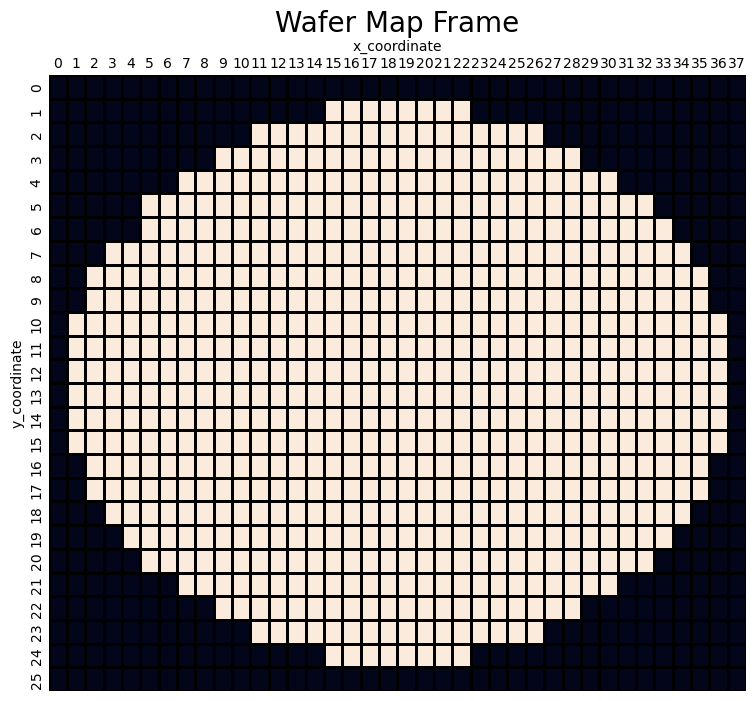

In [18]:
def visualization_wafer(map, size, title):
    plt.figure(figsize=(size+1,size))
    ax = sns.heatmap(map, linewidths=1, linecolor='black', cbar=False)
    plt.xlabel("x_coordinate")
    plt.ylabel("y_coordinate")  
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    plt.title(title, fontsize=20)
    plt.show()
    
visualization_wafer(base_wafer, 8, "Wafer Map Frame")

In [19]:
defectList = []
for fp in path_list:
    cnt = 0
    filename = os.path.splitext(os.path.basename(fp))[0]
    for line in readfile(fp):
        if line[1] == 'DefectList':
            cnt += 1
            
        elif cnt > 0 and line[1].isnumeric():
            tempList = [filename]
            tempList.append(line[1])
            tempList.extend(line[4:6])
            defectList.append(tempList)
            
        elif line[1] == 'SummarySpec':
            break
        
        else:
            continue

defectCols = ['FILE', 'DEFECTID', 'XINDEX', 'YINDEX']
defect_df = pd.DataFrame(defectList, columns=defectCols)
defect_df[["XINDEX", "YINDEX"]] = defect_df[["XINDEX", "YINDEX"]].applymap(lambda x: 0 if x==None else int(x))
defect_df.head()

,FILE,DEFECTID,XINDEX,YINDEX
0,TAGM_REFLOW_INSP3_TAGHN57TA_00-03,1,9,-7
1,TAGM_REFLOW_INSP3_TAGHN57TA_00-03,1,0,0
2,TAGM_REFLOW_INSP3_TAGHN57TA_00-03,2,0,0
3,TAGM_REFLOW_INSP3_TAGHN57TA_00-03,2,9,-7
4,TAGM_REFLOW_INSP3_TAGHN57TA_00-03,3,0,0


In [20]:
defectList = []
for fp in path_list:
    cnt = 0
    filename = os.path.splitext(os.path.basename(fp))[0]
    for line in readfile(fp):
        if line[1] == 'DefectList':
            defectRow = int(line[0])
            cnt += 1
            
        elif line[1] == 'DefectRecordSpec':
            defectColsNum = len(line[3:])
            
        elif cnt > 0 and line[1].isnumeric():
            tempList = [filename]
            tempList.append(line[1])
            tempList.extend(line[4:6])
            defectList.append(tempList)
            
        elif line[1] == 'SummarySpec':
            break
        
        else:
            continue
        
    if not readfile(fp)[defectRow][1].isnumeric():
        tempList = [filename]
        tempList.extend(np.zeros(3).tolist())
        defectList.append(tempList)
    
defectCols = ['FILE', 'DEFECTID', 'XINDEX', 'YINDEX']
defect_df = pd.DataFrame(defectList, columns=defectCols)
defect_df[["XINDEX", "YINDEX"]] = defect_df[["XINDEX", "YINDEX"]].applymap(lambda x: 0 if x==None else int(x))

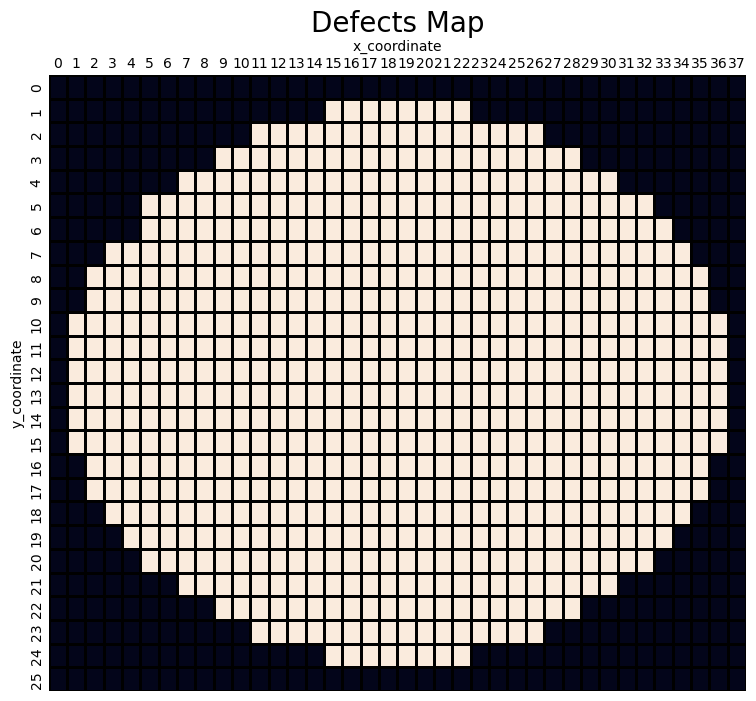

In [21]:
# defect 시각화
defectMaps=[]
for fp in path_list:
    base = base_wafer.copy()
    filename = os.path.splitext(os.path.basename(fp))[0]
    defect_x = defect_df[defect_df.FILE == filename][["XINDEX"]].astype('int').values
    defect_y = defect_df[defect_df.FILE == filename][["YINDEX"]].astype('int').values
    
    if (defect_x == 0).all():
        pass
    else:
        for i in range(defect_x.size):
            base[defect_x[i][0], defect_y[i][0]] = 0.5
    defectMaps.append(base)
    
# 임의의 defect map 시각화
visualization_wafer(defectMaps[0],8, "Defects Map")

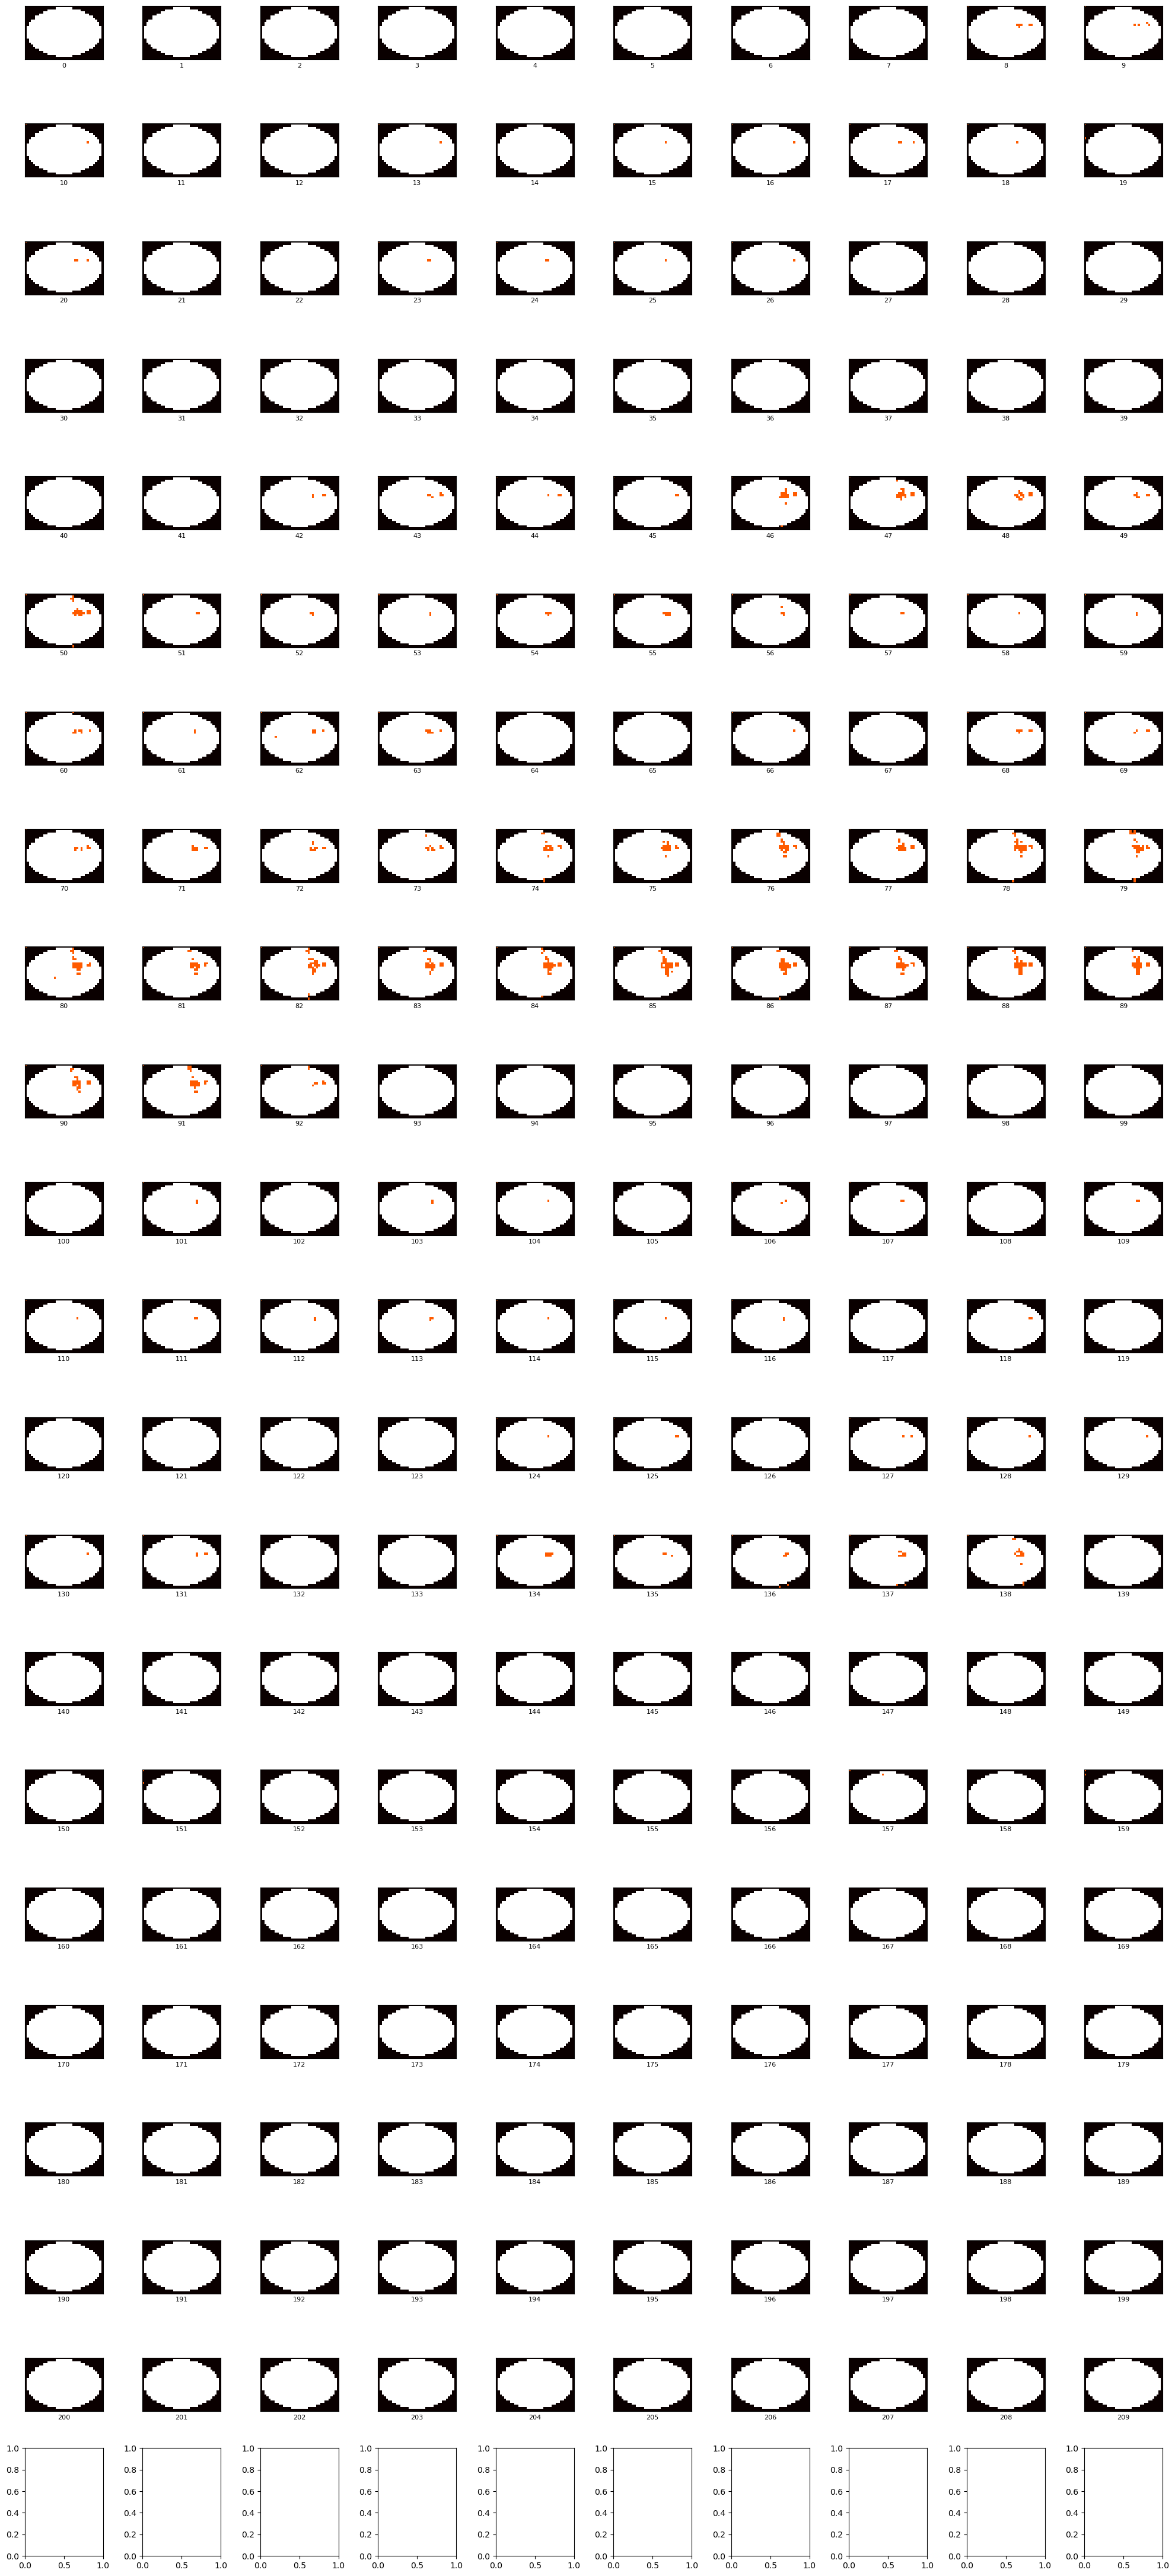

In [22]:
# 다중 wafer 시각화 (단순 추이를 보기 위함.)

fig, ax = plt.subplots(nrows=len(defectMaps)//10+1, ncols=10, figsize=(20,2*(len(defectMaps)//10+1)))
ax = ax.ravel(order='C')
for i in range((len(defectMaps)//10+1)*10):
    try:
        ax[i].imshow(defectMaps[i], cmap=cm.hot)
        ax[i].set_xlabel(f'{i}', fontsize=8)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
    except:
        pass
plt.tight_layout()
plt.show()

## 분석용 데이터 생성

In [23]:
temp_df.head()

,filename,lotid,timestamp,machineid,stepid,deviceid
0,TAGS_REFLOW_INSP3_TAGHQ18T_00-08,TAGHQ18T,2022-12-07 14:34:18,M08AWD10,WAFER REFLOW INSP3,TAGHQ18T
1,TAGS_REFLOW_INSP3_TAGHS57T_00-22,TAGHS57T,2022-12-07 14:42:13,M08AWD10,WAFER REFLOW INSP3,TAGHS57T
2,TAGM_REFLOW_INSP3_TAGHB30TA_00-01,TAGHB30TA,2022-12-07 15:55:40,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA
3,TAGM_REFLOW_INSP3_TAGHB30TA_00-10,TAGHB30TA,2022-12-07 16:02:52,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA
4,TAGM_REFLOW_INSP3_TAGHB30TA_00-12,TAGHB30TA,2022-12-07 16:10:13,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA


In [24]:
defect_df["map"] = defect_df[["XINDEX", "YINDEX"]].apply(list, axis=1)
defect_df.head(3)

,FILE,DEFECTID,XINDEX,YINDEX,map
0,MI_MONITORING_KMIB086T_00-01,0.0,0,0,"[0, 0]"
1,TAGM_REFLOW_INSP3_TAGHB30TA_00-01,0.0,0,0,"[0, 0]"
2,TAGM_REFLOW_INSP3_TAGHB30TA_00-10,0.0,0,0,"[0, 0]"


In [25]:
def appendFn(*listset):
    lst = []
    for list_ in listset:
        lst.append(list_)
    return lst

defect_temp = defect_df.groupby(['FILE'])["map"].apply(appendFn).reset_index()
defect_temp.map = defect_temp.map.apply(lambda x: np.array(x).squeeze(0))
defect_temp

,FILE,map
0,MI_MONITORING_KMIB086T_00-01,"[[0, 0]]"
1,TAGM_REFLOW_INSP3_TAGHB30TA_00-01,"[[0, 0]]"
2,TAGM_REFLOW_INSP3_TAGHB30TA_00-10,"[[0, 0]]"
3,TAGM_REFLOW_INSP3_TAGHB30TA_00-12,"[[0, 0]]"
4,TAGM_REFLOW_INSP3_TAGHB30TA_00-13,"[[0, 0]]"
...,...,...
205,TDAS_REFLOW_INSP3_TDAJN10T_00-20,"[[0, 0]]"
206,TDAS_REFLOW_INSP3_TDAJN10T_00-22,"[[0, 0]]"
207,TDAS_REFLOW_INSP3_TDAJN10T_00-23,"[[0, 0]]"
208,TDAS_REFLOW_INSP3_TDAJN10T_00-24,"[[0, 0]]"


In [26]:
df = pd.merge(temp_df, defect_temp, how='inner', left_on='filename', right_on='FILE').drop(columns=["FILE", "filename"])
df.head()

,lotid,timestamp,machineid,stepid,deviceid,map
0,TAGHQ18T,2022-12-07 14:34:18,M08AWD10,WAFER REFLOW INSP3,TAGHQ18T,"[[0, 0]]"
1,TAGHS57T,2022-12-07 14:42:13,M08AWD10,WAFER REFLOW INSP3,TAGHS57T,"[[9, -7], [0, 0], [0, 0], [9, -7], [0, 0], [0,..."
2,TAGHB30TA,2022-12-07 15:55:40,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA,"[[0, 0]]"
3,TAGHB30TA,2022-12-07 16:02:52,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA,"[[0, 0]]"
4,TAGHB30TA,2022-12-07 16:10:13,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA,"[[0, 0]]"


In [27]:
df

,lotid,timestamp,machineid,stepid,deviceid,map
0,TAGHQ18T,2022-12-07 14:34:18,M08AWD10,WAFER REFLOW INSP3,TAGHQ18T,"[[0, 0]]"
1,TAGHS57T,2022-12-07 14:42:13,M08AWD10,WAFER REFLOW INSP3,TAGHS57T,"[[9, -7], [0, 0], [0, 0], [9, -7], [0, 0], [0,..."
2,TAGHB30TA,2022-12-07 15:55:40,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA,"[[0, 0]]"
3,TAGHB30TA,2022-12-07 16:02:52,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA,"[[0, 0]]"
4,TAGHB30TA,2022-12-07 16:10:13,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA,"[[0, 0]]"
...,...,...,...,...,...,...
205,TDAJL86T,2023-02-06 17:52:31,M08AWD10,WAFER REFLOW INSP3,TDAJL86T,"[[0, 0]]"
206,TDAJL86T,2023-02-06 17:59:42,M08AWD10,WAFER REFLOW INSP3,TDAJL86T,"[[0, 0]]"
207,TDAJL86T,2023-02-06 18:07:09,M08AWD10,WAFER REFLOW INSP3,TDAJL86T,"[[0, 0]]"
208,TDAJL86T,2023-02-06 18:14:31,M08AWD10,WAFER REFLOW INSP3,TDAJL86T,"[[0, 0]]"


## 연속성 판정을 위한 Feature Engineering

1. Defects의 좌표를 거리와 각도로 표현.
2. 시계열순으로 Shift하여 데이터 batch 생성
3. 생성된 batch에 대해 Fast Fourier Transform

In [28]:
# hyperparameter
class cfg:
    seed = 1234
    n_window = 3 # 한 batch에 확인할 wafer 수 -> 10
    origin = [(base_wafer.shape[0]-1)/2, (base_wafer.shape[1]-1)/2]
    #origin = [12.5, 13.5] # wafer의 원점 정의

In [29]:
# batch dataset visualization v2
def dist(origin, defects):
    if defects[0] == [0,0]:
        return [-1]
    distance = [-1]
    for i in range(len(defects)):
        dist = 0
        for j in range(len(defects[i])):
            dist += (origin[j]-defects[i][j])**2
        dist **= 1/2
        distance.append(int(dist))
    return distance

def theta(origin, defects):
    if defects[0] == [0,0]:
        return [-180]
    theta = [-180]
    for i in range(len(defects)):
        rc_x = defects[i][0] - origin[0]
        rc_y = defects[i][1] - origin[1]
        ang = int(np.rad2deg(np.arctan2(rc_y, rc_x)))
        theta.append(ang) # 가시성을 위해 rad -> deg
    return theta

df["distance"] = df.map.apply(lambda x:dist(cfg.origin, x))
df["degree"] = df.map.apply(lambda x:theta(cfg.origin, x))

df.head(30)

,lotid,timestamp,machineid,stepid,deviceid,map,distance,degree
0,TAGHQ18T,2022-12-07 14:34:18,M08AWD10,WAFER REFLOW INSP3,TAGHQ18T,"[[0, 0]]",[-1],[-180]
1,TAGHS57T,2022-12-07 14:42:13,M08AWD10,WAFER REFLOW INSP3,TAGHS57T,"[[9, -7], [0, 0], [0, 0], [9, -7], [0, 0], [0,...","[-1, 25, 22, 22, 25, 22, 22, 25, 22, 22, 25, 2...","[-180, -97, -124, -124, -97, -124, -124, -97, ..."
2,TAGHB30TA,2022-12-07 15:55:40,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA,"[[0, 0]]",[-1],[-180]
3,TAGHB30TA,2022-12-07 16:02:52,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA,"[[0, 0]]",[-1],[-180]
4,TAGHB30TA,2022-12-07 16:10:13,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA,"[[0, 0]]",[-1],[-180]
5,TAGHB30TA,2022-12-07 16:18:02,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA,"[[0, 0]]",[-1],[-180]
6,TAGHB30TA,2022-12-07 16:25:24,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA,"[[0, 0]]",[-1],[-180]
7,TAGHB30TA,2022-12-07 16:33:18,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA,"[[0, 0]]",[-1],[-180]
8,TAGHB30TA,2022-12-07 16:40:32,M08AWD10,WAFER REFLOW INSP3,TAGHB30TA,"[[0, 0]]",[-1],[-180]
9,TAGHN57TA,2022-12-07 16:49:04,M08AWD10,WAFER REFLOW INSP3,TAGHN57TA,"[[9, -7], [0, 0], [0, 0], [9, -7], [0, 0], [0,...","[-1, 25, 22, 22, 25, 22, 22, 25, 22, 22, 25, 2...","[-180, -97, -124, -124, -97, -124, -124, -97, ..."


In [30]:
def batch_graph(degree, distance, graph=True):
    intp = interpolate.interp1d(degree, distance, kind='linear') # linear, cubic, nearest ...
    xnew = np.arange(min(degree), max(degree), 0.1)
    
    if graph:
        fig = plt.figure(figsize=(5,2))
        plt.plot(degree, distance, "ro", xnew, intp(xnew))
        plt.xlim([-180, -180+360*cfg.n_window])
        #plt.ylim([0, 30])
        xtick = np.array(degree) % 360
        plt.xticks(degree, xtick, rotation=45)
        plt.show()
    return intp, xnew

# FFT graph
def fft_graph(input, graph=True):
    Y = np.fft.fft(input)
    amp = abs(Y) * (2/len(Y))
    freq = np.fft.fftfreq(len(Y), 1/1000)

    amp = amp[0:20]
    freq = freq[0:20]
    
    if graph:
        plt.figure(figsize=(5,2))
        plt.stem(freq, amp)
        plt.grid(True)
        plt.show()
    return amp

In [31]:
# 전체 데이터에 대해 진행.
def amp_data(input):
    Y = np.fft.fft(input)
    amp = abs(Y) * (2/len(Y))
    return amp[0:20]

In [32]:
# fft그래프 visualization
def visualization_graph(df, case, graph=True):
    df["Case"] = case
    nRows = len(df) - cfg.n_window + 1
    for i in range(nRows):
        df_dist = df.distance[i:cfg.n_window + i].tolist()
        batch_dist = []
        for dist in df_dist:
            try:
                for d in dist:
                    batch_dist.append(d)
            except:
                pass
        df_deg = df.degree[i:cfg.n_window + i].tolist()
        batch_deg = []
        for n, deg in enumerate(df_deg):
            try:
                for d in deg:
                    batch_deg.append(d + 360*n)
            except:
                pass
        batch_dist.append(-1)    
        batch_deg.append(-180 + 360*(n+1))    
            
        print(f"Index_{df.at[i+cfg.n_window-1, 'index']}")
        intp, xnew = batch_graph(batch_deg, batch_dist, graph)
        fft_graph(intp(xnew), graph)
    return 

Case9: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHX17T')
Index_48


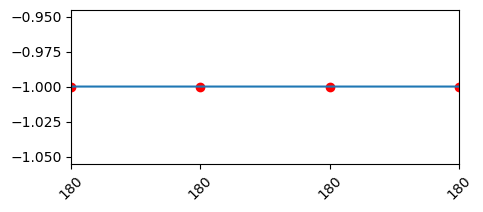

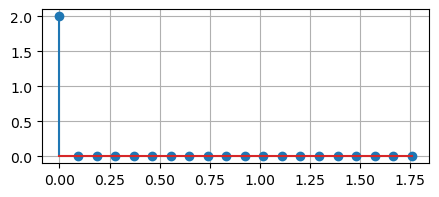

Index_49


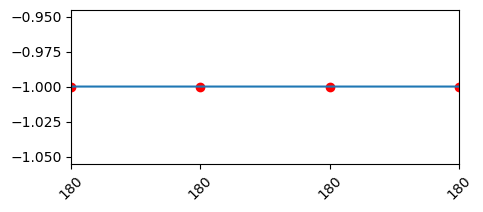

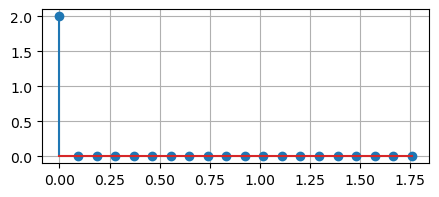

Index_50


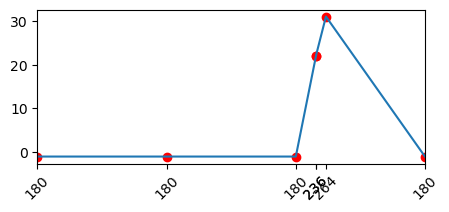

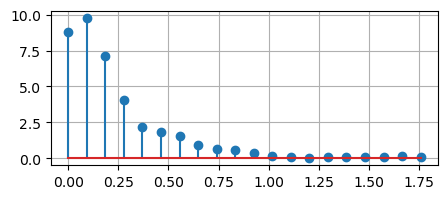

Index_51


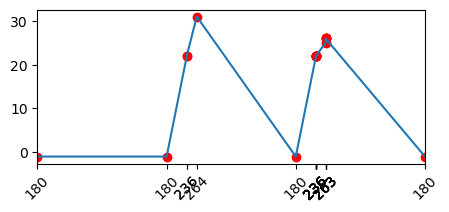

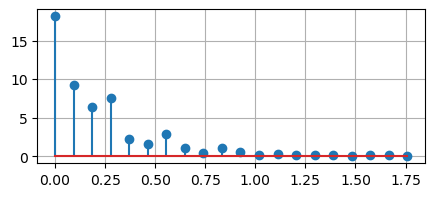

Index_52


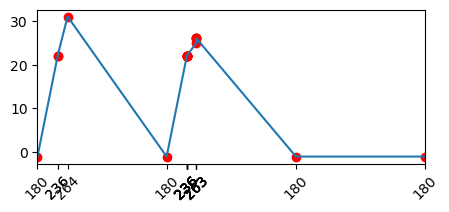

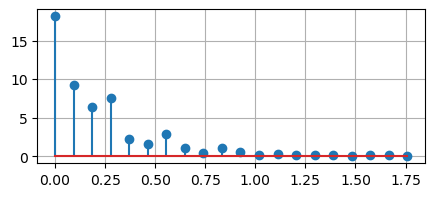

Index_53


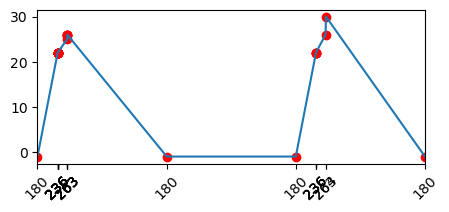

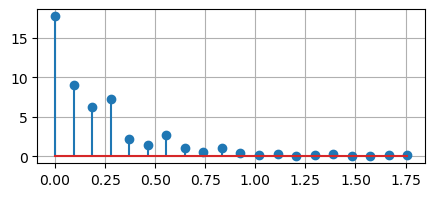

Index_54


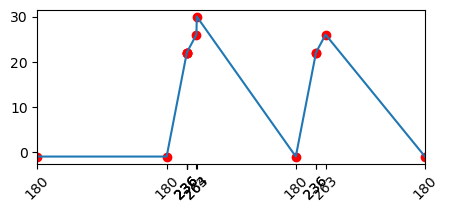

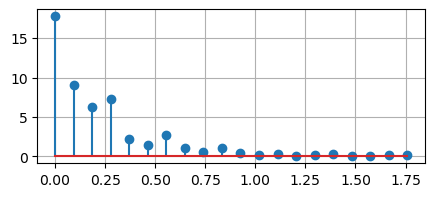

Index_55


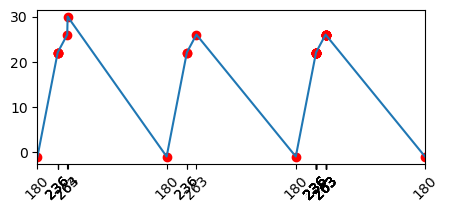

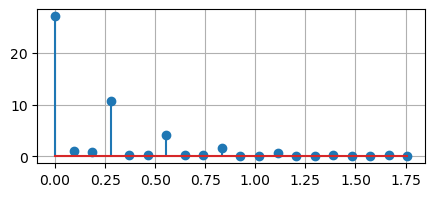

Index_56


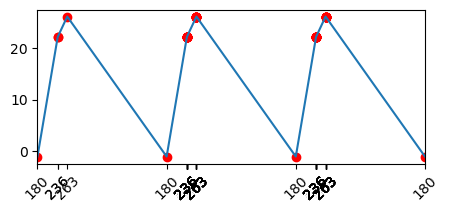

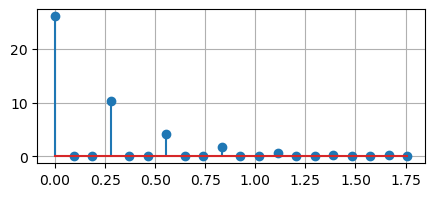

Index_57


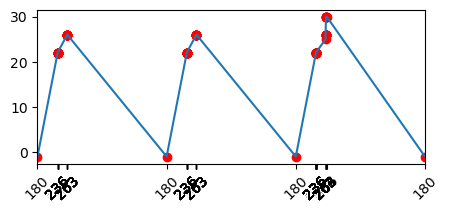

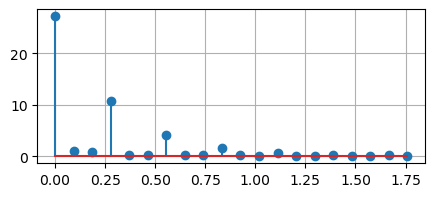

Case10: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHS57TA')
Index_60


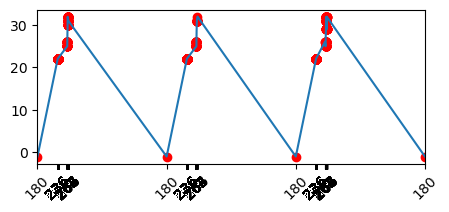

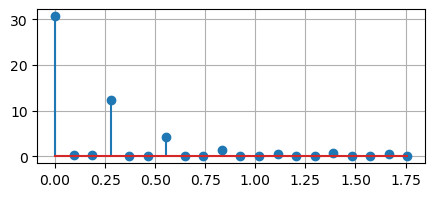

Index_61


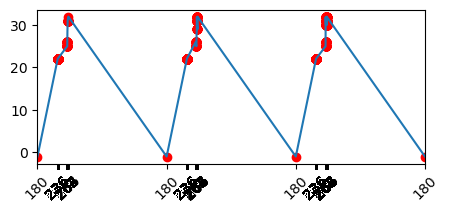

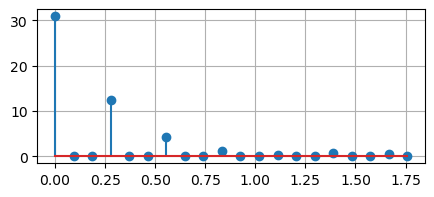

Index_62


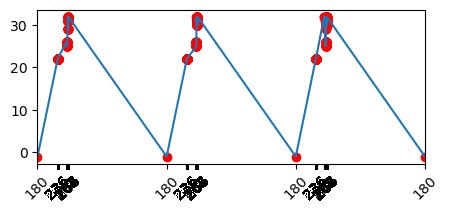

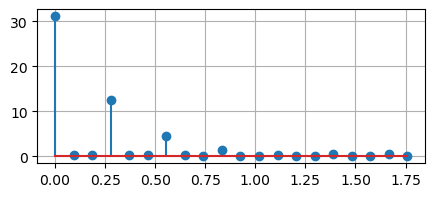

Index_63


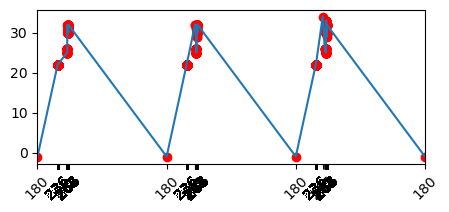

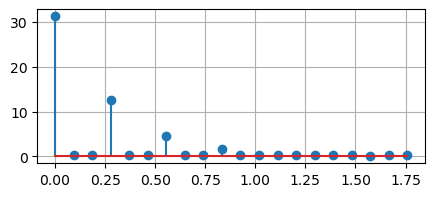

Index_64


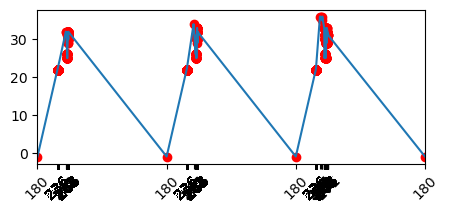

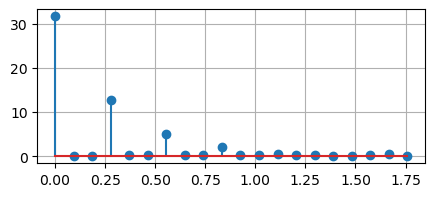

Index_65


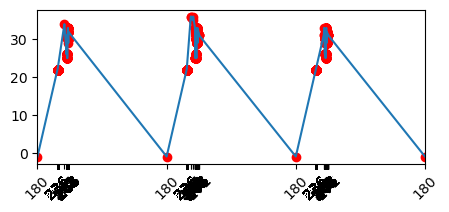

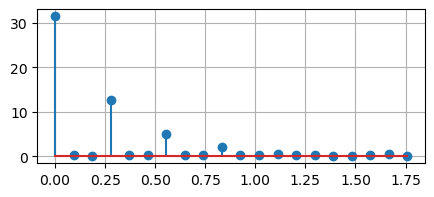

Index_66


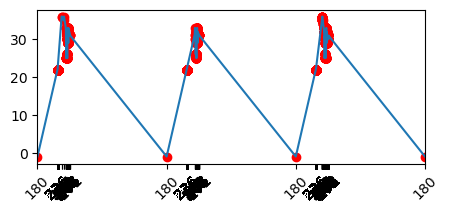

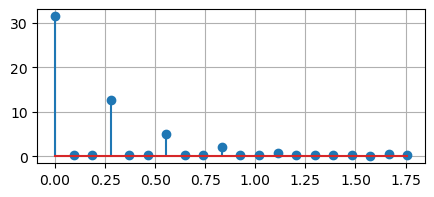

Index_67


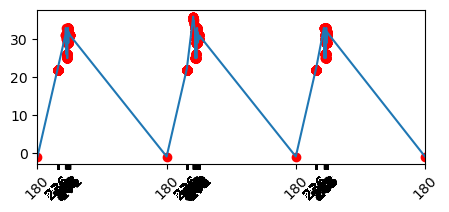

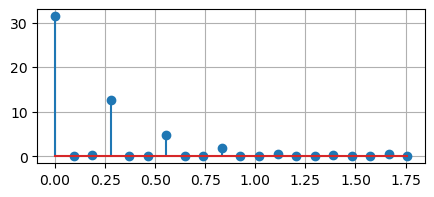

Index_68


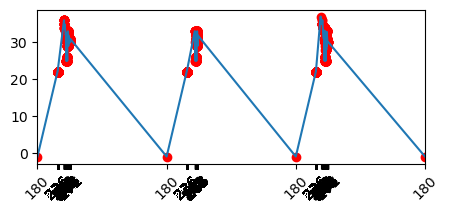

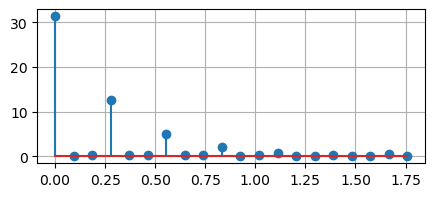

Index_69


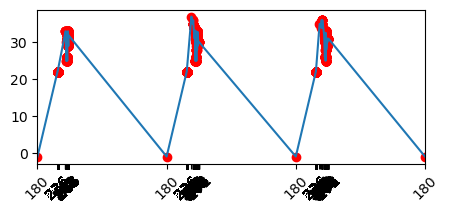

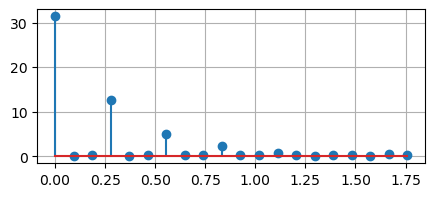

Index_70


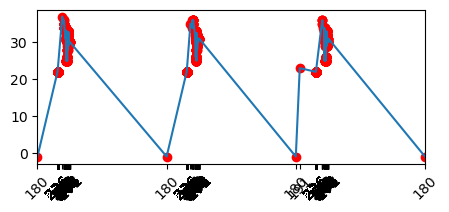

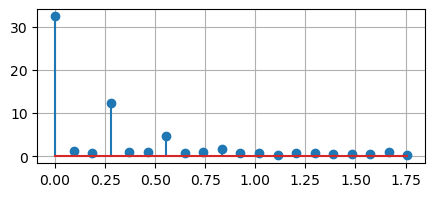

Index_71


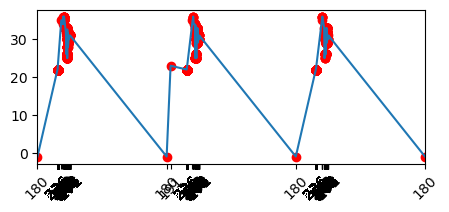

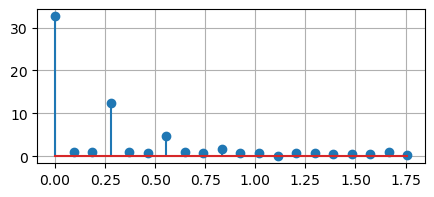

Index_72


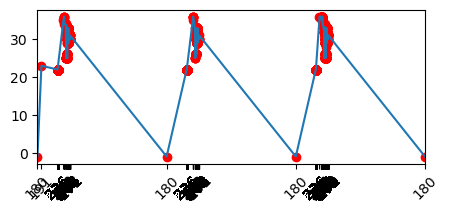

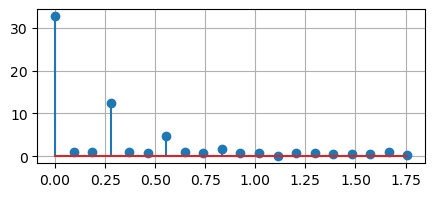

Index_73


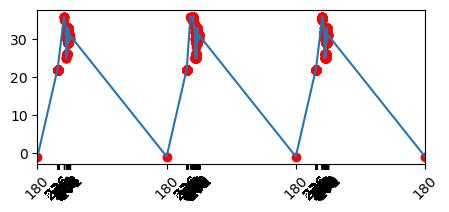

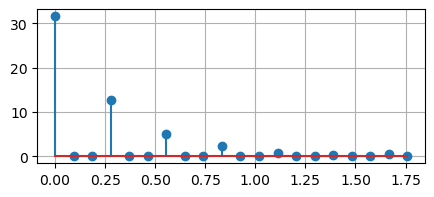

Index_74


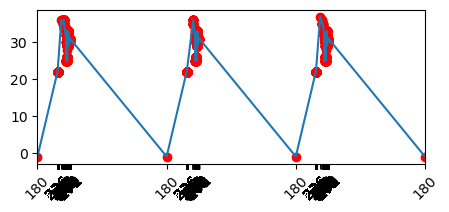

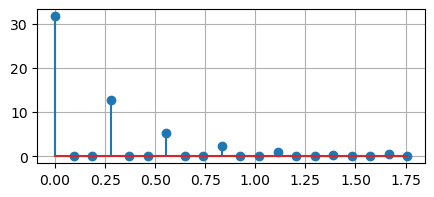

Index_75


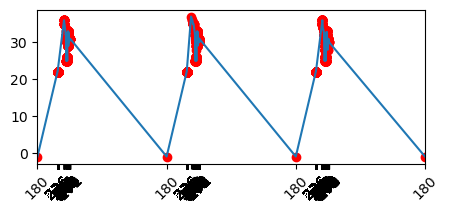

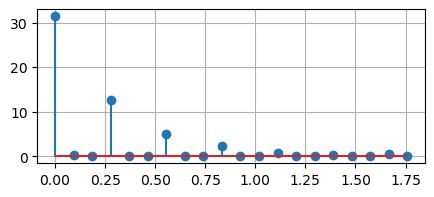

Index_76


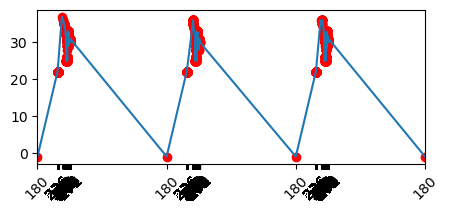

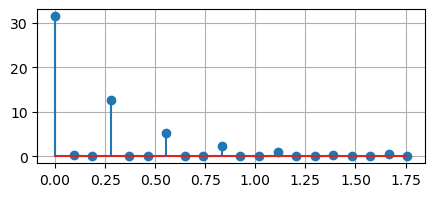

Index_77


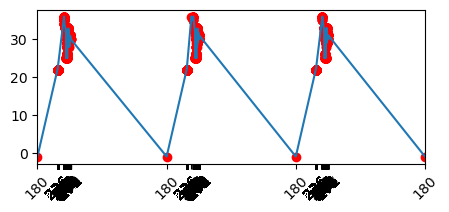

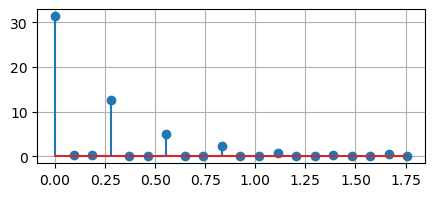

Index_78


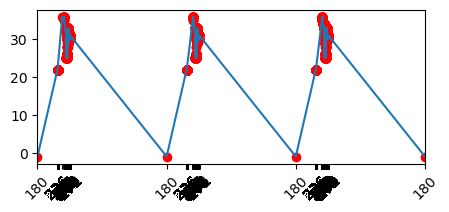

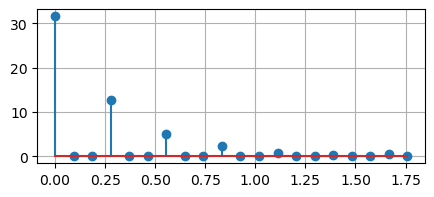

Index_79


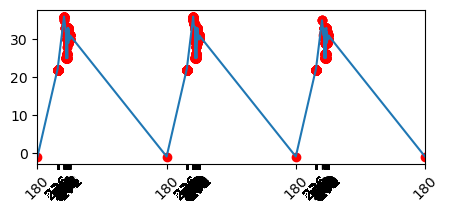

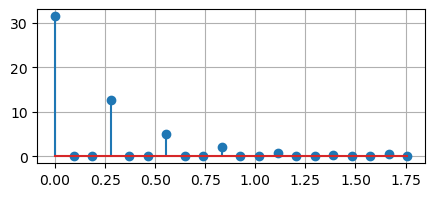

Index_80


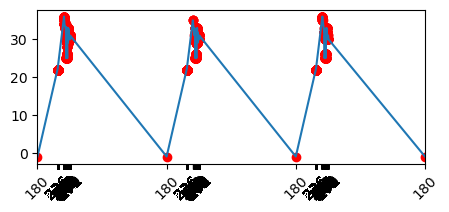

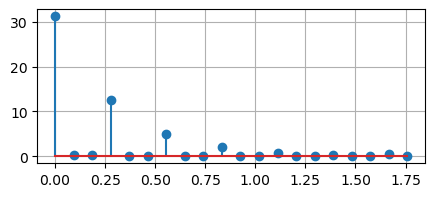

Index_81


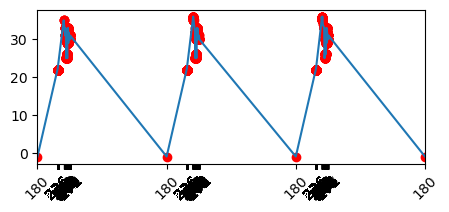

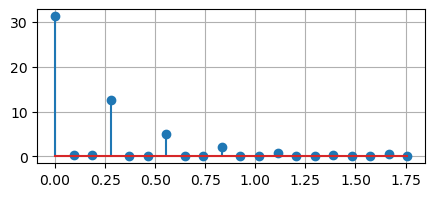

In [33]:
# 정상 / 이상 데이터에 대한 예시 그래프
machine_type = df["machineid"].unique()
step_type = df["stepid"].unique()
device_type = df["deviceid"].unique()

temp_df = df.copy()

case = 0
case_dict = dict()
for m in machine_type:
    for s in step_type:
        for d in device_type:
            case += 1
            if case in [9,10] :
                print("==="*30)
                print(f"Case{case}: {m,s,d}")
                case_dict["Case"+str(case)] = [m,s,d]
                    
                temp = df[(df.machineid == m) & (df.stepid == s) & (df.deviceid == d)].reset_index()
                if len(temp) == 0:
                    print("데이터 없음")
                    continue
                
                visualization_graph(temp, case, True)
                print("==="*30)

In [36]:
# fft후, amplitude 값 컬럼 추가
def add_amplitude(df):
    nRows = len(df) - cfg.n_window + 1
    for i in range(nRows):
        df_dist = df.distance[i:cfg.n_window + i].tolist()
        batch_dist = []
        for dist in df_dist:
            try:
                for d in dist:
                    batch_dist.append(d)
            except:
                pass
            
        df_deg = df.degree[i:cfg.n_window + i].tolist()
        batch_deg = []
        for n, deg in enumerate(df_deg):
            try:
                for d in deg:
                    batch_deg.append(d + 360*n)
            except:
                pass
        
        intp, xnew = batch_graph(batch_deg, batch_dist, False)
        df.at[i+cfg.n_window-1,"amplitude"] = amp_data(intp(xnew)).astype('object')
    return df

In [37]:
# amplitude, case 컬럼 추가
machine_type = df["machineid"].unique()
step_type = df["stepid"].unique()
device_type = df["deviceid"].unique()

temp_df = pd.DataFrame()
case = 0
for m in machine_type:
    for s in step_type:
        for d in device_type:
            case += 1
            print(f"Case{case}: {m,s,d}")
            temp = df[(df.machineid == m) & (df.stepid == s) & (df.deviceid == d)].reset_index()
            if len(temp) == 0:
                print("데이터프레임 없음")
                continue
            
            temp = add_amplitude(temp)
            temp['case'] = case
            temp_df = pd.concat([temp_df, temp], axis=0)
temp_df = temp_df.sort_values(by='index').reset_index(drop=True)

Case1: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHQ18T')
Case2: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHS57T')
Case3: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHB30TA')
Case4: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHN57TA')
Case5: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHD39TF')
Case6: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHU26TA')
Case7: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHW48TA')
Case8: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHX32TA')
Case9: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHX17T')
Case10: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHS57TA')
Case11: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGH734TA')
Case12: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGH973TA')
Case13: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHC32TF')
Case14: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHA10TA')
Case15: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHC65TA')
Case16: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGH992TB')
Case17: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHA04TA')
Case18: ('M08AWD10', 'WAFER REFLOW INSP3', 'TAGHY65T')
Case1

In [38]:
data = temp_df[["amplitude", "case"]]

# null값 제거
data = data[data.amplitude.notnull()]
data

,amplitude,case
4,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
5,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
6,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
7,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
8,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
...,...,...
205,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",27
206,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",27
207,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",27
208,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",27


In [40]:
# Class 라벨 추가
klarf_info = pd.read_csv("./klarf_scenario.txt", sep='\t')
klarf_info[klarf_info.Class != 0] = 1
temp_class = data.copy()
temp_class["class"] = klarf_info.Class
temp_class

,amplitude,case,class
4,"[1.1365575147692653e-13, 1.6192659676815115, 0...",10,0
5,"[1.146801705755631, 2.96404876893771, 2.465994...",1,0
6,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10,0
7,"[4.665277777778155, 5.3708632752941865, 2.6225...",1,0
8,"[2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10,0
...,...,...,...
995,"[4.626047904191197, 3.3859911884807077, 2.7075...",9,0
996,"[8.302561669828556, 2.244704822194835, 0.72627...",9,0
997,"[8.154513888887763, 2.1717257982185796, 1.5454...",9,0
998,"[8.176097105508994, 4.171502919051563, 1.60114...",9,0


In [39]:
def make_amplitude_df(df):
    arr = np.array(df.amplitude.iloc[0]).reshape(1,-1)
    cols = np.array([i for i in range(arr.shape[1])])
    idx = df.index
    for i in range(1,len(df)):
        arr = np.append(arr, df.amplitude.iloc[i].reshape(1,-1), axis=0)
        
    df = pd.DataFrame(arr, columns=cols, index=idx)
    return df
make_amplitude_df(temp_class)

NameError: name 'temp_class' is not defined

## data

In [473]:
data_X = make_amplitude_df(temp_class).iloc[:,1:]
data_y = temp_class[["class"]]

train_clf_X, test_clf_X, train_clf_y ,test_clf_y = train_test_split(
    data_X, data_y, test_size=0.3, random_state=cfg.seed
)

In [40]:
def fft_plot(arr):
    plt.stem(arr, colors=sk_red)
    plt.show()
    
fft_plot(train_clf_X.iloc[2,:])

NameError: name 'train_clf_X' is not defined

## Normalization


In [475]:
from sklearn.preprocessing import Normalizer

norm = Normalizer(norm='max')
train_clf_X = pd.DataFrame(norm.fit_transform(train_clf_X), index=train_clf_X.index)
test_clf_X = norm.transform(test_clf_X)

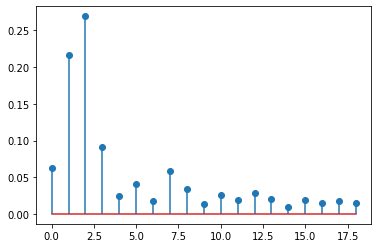

In [458]:
fft_plot(train_clf_X.iloc[2, :])
    

## 프로토타입 모델링
- RandomForest로 확인

In [441]:
# random forest
rf = RandomForestClassifier(random_state=cfg.seed)
rf.fit(train_clf_X, train_clf_y)
joblib.dump(rf, './model/basic_rf.pkl')

['./model/basic_rf.pkl']

In [442]:
def plot_heatmap(actual, predicted, title):
    ax = plt.subplot()
    sns.heatmap(confusion_matrix(actual, predicted), annot=True, fmt='d', cbar=False, ax=ax)
    ax.set_xlabel("Predicted", fontsize=13)
    ax.set_ylabel("Actual", fontsize=13)
    ax.xaxis.set_ticklabels(["Normal", "Anomaly"])
    ax.yaxis.set_ticklabels(["Normal", "Anomaly"])
    ax.set_title(title, fontsize=15)
    plt.show()
    
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

def plot_comp(proba, actual):
    threshold_arr = np.linspace(0, 1, 20)
    acc_arr = []
    rec_arr = []
    pre_arr = []
    for th in threshold_arr:
        predicted = (proba[:,1] >= th).astype('int')
        acc_arr.append(accuracy_score(actual, predicted))
        rec_arr.append(recall_score(actual, predicted))
        pre_arr.append(precision_score(actual, predicted))

    plt.plot(threshold_arr, acc_arr, 'g', label='accuracy score')
    plt.plot(threshold_arr, rec_arr, 'r', label='recall score')
    plt.plot(threshold_arr, pre_arr, 'b', label='precision score')
    # plt.axhline(y=0.9, color='k', linestyle='--')
    # plt.axvline(x=0.25, color='k', linestyle='--')
    plt.title("Precision and Recall score comparision", fontsize=20)
    plt.xlabel("Threshold", fontsize=15)
    plt.xticks(np.arange(0,1.1,.1))
    plt.ylabel("Score", fontsize=15)
    plt.legend()
    plt.show()
    

accuracy_score: 0.949, recall score: 0.829, f1 score: 0.986
roc-auc score:  0.96


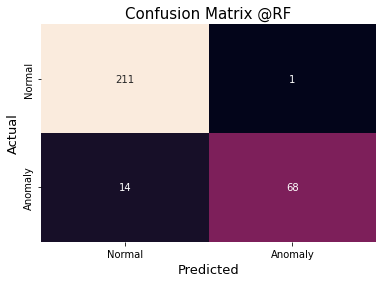

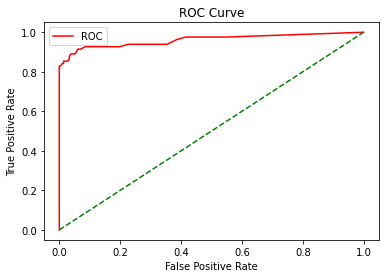

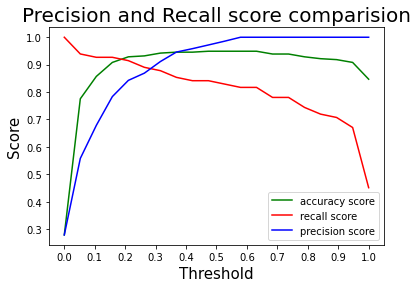

In [443]:
def plot_all(model, df_X, df_y, model_name):

    pred = model.predict(df_X)
    acc = accuracy_score(df_y, pred)
    rec = recall_score(df_y, pred)
    pre = precision_score(df_y, pred) 
    print("accuracy_score: {:.3f}, recall score: {:.3f}, f1 score: {:.3f}".format(acc, rec, pre))
    
    prob = model.predict_proba(df_X)[:,1]
    fper, tper, thresholds = roc_curve(df_y, prob)
    print('roc-auc score: ', round(roc_auc_score(df_y,prob),2))

    predicted_proba = model.predict_proba(df_X)

    plot_heatmap(df_y, pred, f"Confusion Matrix @{model_name}")
    plot_roc_curve(fper, tper)
    plot_comp(predicted_proba, df_y)
    
plot_all(rf, test_clf_X, test_clf_y, "RF")

## 모델링


### SVC

accuracy_score: 0.915, recall score: 0.768, f1 score: 0.913
roc-auc score:  0.89


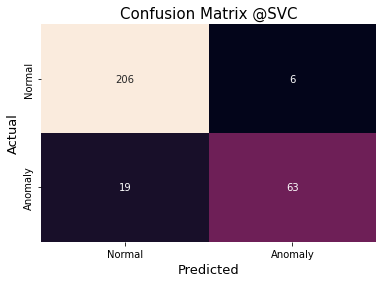

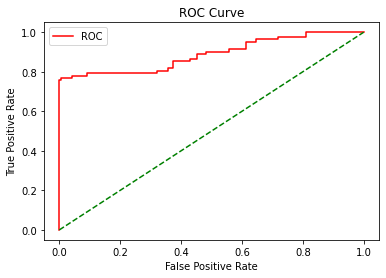

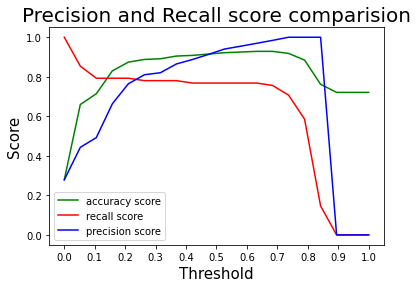

In [542]:
# svc
from sklearn.svm import SVC
model = SVC(kernel='linear', random_state=cfg.seed, probability=True)
model.fit(train_clf_X, train_clf_y)
saved_model = joblib.dump(model, './model/basic_svc.pkl')
plot_all(model, test_clf_X,  test_clf_y, "SVC")

accuracy_score: 0.908, recall score: 0.768, f1 score: 0.887
roc-auc score:  0.88


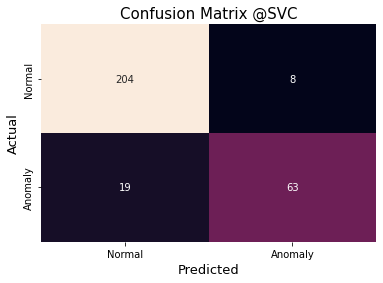

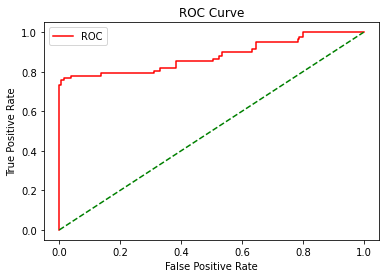

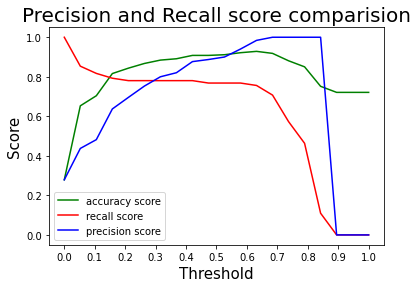

In [506]:
# SVC
from sklearn.svm import SVC
model = SVC(C=0.3, kernel='linear', random_state=cfg.seed, probability=True)
model.fit(train_clf_X, train_clf_y)
saved_model = joblib.dump(model, './model/tuned_svc.pkl')
plot_all(model, test_clf_X,  test_clf_y, "SVC")

accuracy_score: 0.908, recall score: 0.768, f1 score: 0.887


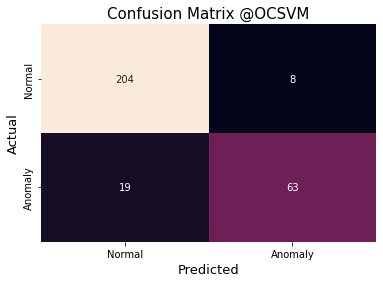

In [538]:
# OC SVM
from sklearn.svm import OneClassSVM
ocsvm = OneClassSVM(kernel='linear')

ocsvm.fit(train_clf_X, train_clf_y)
joblib.dump(model, './model/basic_ocsvm.pkl')

pred = model.predict(test_clf_X)
acc = accuracy_score(test_clf_y, pred)
rec = recall_score(test_clf_y, pred)
pre = precision_score(test_clf_y, pred) 
print("accuracy_score: {:.3f}, recall score: {:.3f}, f1 score: {:.3f}".format(acc, rec, pre))
plot_heatmap(test_clf_y, pred, "Confusion Matrix @OCSVM")


### Logistic Regression

In [447]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=cfg.seed)
model.fit(train_clf_X, train_clf_y)
saved_model = joblib.dump(model, './model/basic_lr.pkl')

accuracy_score: 0.915, recall score: 0.768, f1 score: 0.913
roc-auc score:  0.88


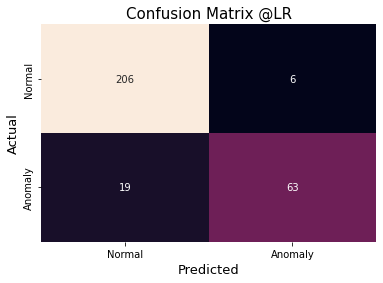

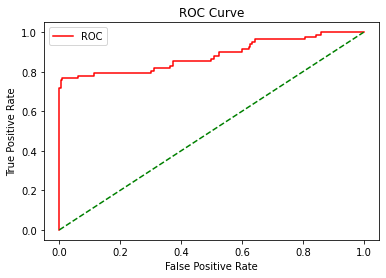

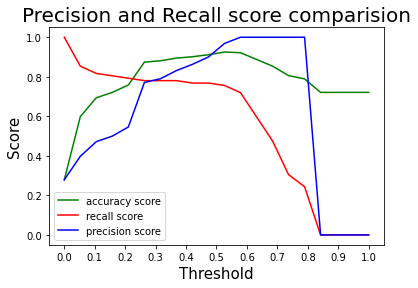

In [448]:
plot_all(model, test_clf_X,  test_clf_y, "LR")

## SVC 시각화

In [580]:
from sklearn.decomposition import PCA

# 1~19까지의 컬럼에 대해 주성분분석 후, 2차원/3차원 상에 투상
norm = Normalizer(norm='max')
norm_X = norm.fit_transform(data_X)

pca = PCA(n_components=2, random_state=cfg.seed)
pca_X = pca.fit_transform(norm_X)

pca3 = PCA(n_components=3, random_state=cfg.seed)
pca3_X = pca3.fit_transform(norm_X)

mod_visual = SVC(kernel='linear', random_state=cfg.seed)
mod_visual.fit(pca3_X, data_y)

mod_ocsvm = OneClassSVM(kernel='linear')
mod_ocsvm.fit(pca3_X, data_y)

pca_df = pd.DataFrame(pca_X, index=data_X.index, columns=['x','y'])
pca_df = pd.concat([pca_df, data_y], axis=1)
pca3_df = pd.DataFrame(pca3_X, index=data_X.index, columns=['x','y','z'])
pca3_df = pd.concat([pca3_df, data_y], axis=1)

pca_df0 = pca_df[pca_df["class"] == 0]
pca_df1 = pca_df[pca_df["class"] == 1]

pca3_df0 = pca3_df[pca3_df["class"] == 0]
pca3_df1 = pca3_df[pca3_df["class"] == 1]

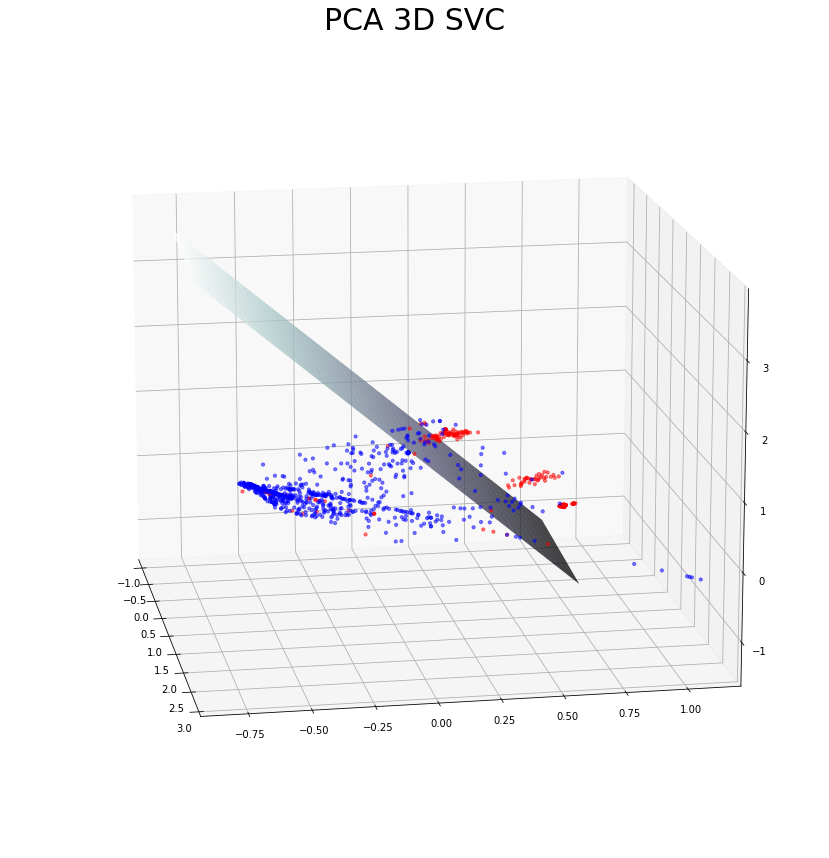

In [611]:
# 3차원 SVM 시각화
z = lambda x,y: (-mod_visual.intercept_[0]-mod_visual.coef_[0][0]*x-mod_visual.coef_[0][1]*y) / mod_visual.coef_[0][2]

tmp = np.linspace(-0.8,0.8,100)
x,y = np.meshgrid(tmp,tmp)

# Plot stuff.
fig = plt.figure(figsize=(20,15))
ax  = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z(x,y), cmap=cm.bone)
ax.scatter(pca3_df0['x'], pca3_df0['y'], pca3_df0['z'], s=10, color='b', alpha=0.5, label='Normal')
ax.scatter(pca3_df1['x'], pca3_df1['y'], pca3_df1['z'], s=10, color='r', alpha=0.5, label='Anomaly')
ax.view_init(elev=15., azim=350)
plt.title("PCA 3D SVC", fontsize=30)
plt.show()

## 예측값으로부터 이상원인 파악

In [170]:
temp = pd.DataFrame(pred, index=test_clf_X.index)
idx = temp[temp[0] == 1].index
anomaly_df = temp_df.iloc[idx,:].drop(columns=["index","MAP","Distance","Degree","Amplitude"]).sort_values("Timestamp")
anomaly_df

,LotID,WaferID,Timestamp,MachineID,StepID,DeviceID,Case
30,AS10003SA,AS10003-04,2023-01-01 10:35:34,A3D02,Metrology-Type-01,AS1,2
47,AS10003SA,AS10003-12,2023-01-01 14:07:57,A3D02,Metrology-Type-01,AS1,2
50,AS10003SA,AS10003-13,2023-01-01 14:40:04,A3D02,Metrology-Type-01,AS1,2
52,AS10003SA,AS10003-14,2023-01-01 15:09:43,A3D02,Metrology-Type-01,AS1,2
126,AS10003SC,AS10003-23,2023-01-02 06:17:36,A3D01,Metrology-Type-01,AS1,10
...,...,...,...,...,...,...,...
964,AC10358SP,AC10358-04,2023-01-09 13:21:42,A3D01,Metrology-Type-01,AC1,9
969,AC10358SP,AC10358-07,2023-01-09 14:17:46,A3D01,Metrology-Type-01,AC1,9
970,AC10358SP,AC10358-08,2023-01-09 14:41:09,A3D01,Metrology-Type-01,AC1,9
980,AC10358SP,AC10358-13,2023-01-09 16:49:50,A3D01,Metrology-Type-01,AC1,9


In [190]:
anomaly_df["YMD"] = anomaly_df.Timestamp.apply(lambda x: datetime.strftime(x, "%Y-%m-%d"))
anomaly_df.YMD.unique()
for ymd in anomaly_df.YMD.unique():
    temp = anomaly_df[anomaly_df.YMD == ymd]
    print(f'============= {ymd} =============')
    print(f'검사장비 {temp.MachineID.unique()}')
    print(f'검사방법 {temp.StepID.unique()}')
    print(f'제품공정 {temp.DeviceID.unique()}')
    print("에 대한 확인이 필요합니다.\n")

============= 2023-01-01 =============
검사장비 ['A3D02']
검사방법 ['Metrology-Type-01']
제품공정 ['AS1']
에 대한 확인이 필요합니다.

============= 2023-01-02 =============
검사장비 ['A3D01']
검사방법 ['Metrology-Type-01']
제품공정 ['AS1']
에 대한 확인이 필요합니다.

============= 2023-01-03 =============
검사장비 ['A3D01']
검사방법 ['Metrology-Type-01' 'Metrology-Type-02']
제품공정 ['AS1' 'AC1']
에 대한 확인이 필요합니다.

============= 2023-01-04 =============
검사장비 ['A3D01']
검사방법 ['Metrology-Type-02']
제품공정 ['AS1']
에 대한 확인이 필요합니다.

============= 2023-01-05 =============
검사장비 ['A3D01' 'A3D02']
검사방법 ['Metrology-Type-02' 'Metrology-Type-01']
제품공정 ['AS1']
에 대한 확인이 필요합니다.

============= 2023-01-06 =============
검사장비 ['A3D02']
검사방법 ['Metrology-Type-01']
제품공정 ['AS1']
에 대한 확인이 필요합니다.

============= 2023-01-07 =============
검사장비 ['A3D01']
검사방법 ['Metrology-Type-01']
제품공정 ['AS1']
에 대한 확인이 필요합니다.

============= 2023-01-09 =============
검사장비 ['A3D01']
검사방법 ['Metrology-Type-01']
제품공정 ['AS1' 'AC1']
에 대한 확인이 필요합니다.



## 푸리에 변환의 이해를 위한 예시 시각화

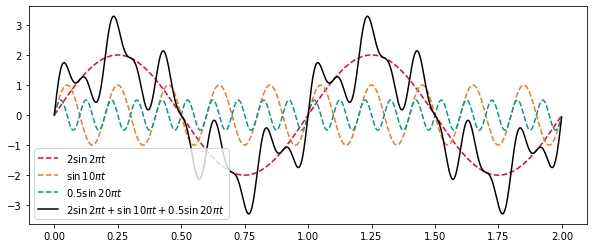

In [622]:
# 푸리에 적분 예시
fig = plt.figure(figsize=(10,4))
x = np.arange(0,2, 0.001)
y1 = 2*np.sin(2*np.pi*x)
y2 = np.sin(2*np.pi*5*x)
y3 = 0.5*np.sin(2*np.pi*10*x)
ySum = y1+y2+y3
plt.plot(x, y1, color=sk_red, linestyle='--', label=r"${2}\sin {2\pi} t$")
plt.plot(x, y2, color=sk_orange, linestyle='--', label=r"$\sin {10\pi} t$")
plt.plot(x, y3, color=sk_teal, linestyle='--', label=r"${0.5}\sin {20\pi} t$")
plt.plot(x,ySum, color='k', label=r"${2}\sin{2\pi}t + \sin{10\pi}t + {0.5}\sin{20\pi}t$")
plt.legend()
plt.show()

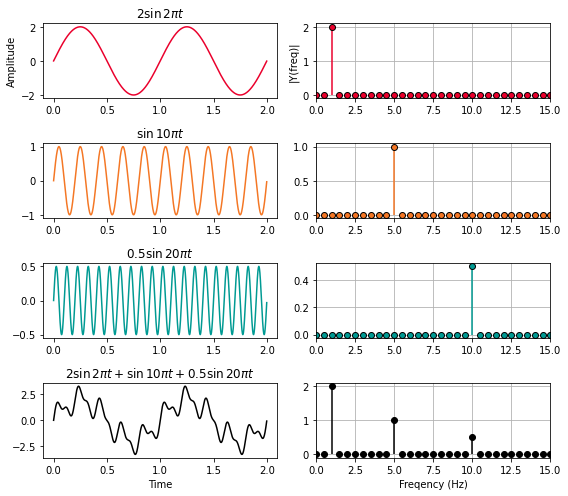

In [627]:
def fft_func(y):
    n = len(y)
    k = np.arange(n)
    Fs = 1/0.001
    T = n/Fs
    freq = k/T 
    freq = freq[range(int(n/2))]
    Y = 2* np.fft.fft(y)/n 
    amp = Y[range(int(n/2))]
    return freq, abs(amp)

def plot_fft(row, col, y, color):
    markers, stemlines, baseline = ax[row][col].stem(fft_func(y)[0], fft_func(y)[1])
    markers.set_color(color)
    markers.set_markeredgecolor('k')
    markers.set_marker('o')
    stemlines.set_color(color)
    baseline.set_visible(False)
    ax[row][col].set_xlim([0, 15])
    ax[row][col].grid()

fig, ax = plt.subplots(4, 2, figsize=(8,7))

ax[0][0].plot(x, y1, sk_red)
ax[1][0].plot(x, y2, sk_orange)
ax[2][0].plot(x, y3, sk_teal)
ax[3][0].plot(x, ySum, 'k')
plot_fft(0,1,y1, sk_red)
plot_fft(1,1,y2, sk_orange)
plot_fft(2,1,y3, sk_teal)
plot_fft(3,1,ySum, 'k')
ax[3][0].set_xlabel('Time')
ax[0][0].set_ylabel('Amplitude')
ax[0][1].set_ylabel('|Y(freq)|')
ax[3][1].set_xlabel('Freqency (Hz)')

ax[0][0].set_title(r"${2}\sin {2\pi} t$")
ax[1][0].set_title(r"$\sin {10\pi} t$")
ax[2][0].set_title(r"${0.5}\sin {20\pi} t$")
ax[3][0].set_title(r"${2}\sin{2\pi}t + \sin{10\pi}t + {0.5}\sin{20\pi}t$")

plt.tight_layout()
plt.show()

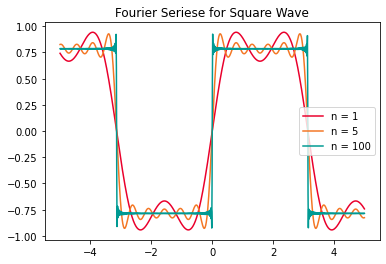

In [631]:
# 주기를 가진 사각파의 삼각함수 근사
def F(n, X):
    """
                   1
        F (t) = ------- sin ( (2n+1) t ) 
         n      2n + 1
    """
    return np.sin((2*n+1)*X)/(2*n+1)


def squarewave(n, X):
    """
          n
        Sigma  F (t)
         k=1
    """
    y = np.zeros(X.shape)
    for k in range(n+1):
        y = F(k, X) + y
    return y

sk_cmap = {0: sk_red,
           1: sk_orange,
           2: sk_teal,
           3: sk_blue,
           4: 'k'}
X = np.linspace(-5, 5, 1000)
for c, i in enumerate([1, 5, 100]):
    plt.plot(X, squarewave(i, X), label = f'n = {i}', color=sk_cmap[c])
    
plt.title("Fourier Seriese for Square Wave")
plt.legend()
plt.show()

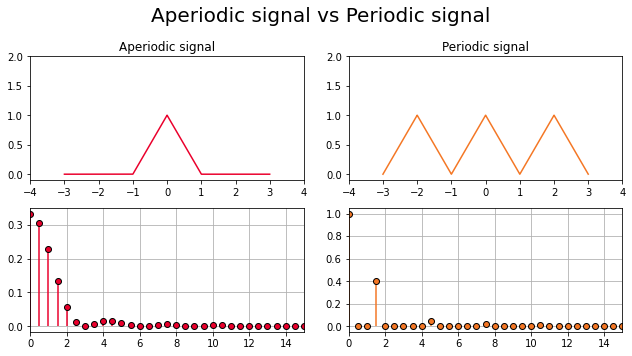

In [633]:
x = np.arange(-3, 3, 0.001)
y = np.array([])
y1 = np.array([])
for i in x:
    if 0 < i <= 1:
        y = np.append(y, -i+1)
        y1 = np.append(y1, -i+1)
    elif -1 < i <= 0:
        y = np.append(y, i+1)
        y1 = np.append(y1, i+1)
    elif -2 < i <= -1:
        y = np.append(y, 0)
        y1 = np.append(y1, -i-1)
    elif -3 < i <= -2:
        y = np.append(y, 0)
        y1 = np.append(y1, i+3)
    elif 1 < i <= 2:
        y = np.append(y, 0)
        y1 = np.append(y1, i-1)
    elif 2 < i <= 3:
        y = np.append(y, 0)
        y1 = np.append(y1, -i+3)
    else:
        y = np.append(y, 0)
        y1 = np.append(y1, 0)

def fft_func(y, sampling_rate=1000):
    n = len(y)
    k = np.arange(n)
    Fs = sampling_rate
    T = n/Fs
    freq = k/T 
    freq = freq[range(int(n/2))]
    Y = 2* np.fft.fft(y)/n 
    amp = Y[range(int(n/2))]
    return freq, abs(amp)

def plot_fft(row, col, y, color, sampling_rate=1000):
    markers, stemlines, baseline = ax[row][col].stem(fft_func(y, sampling_rate)[0], fft_func(y, sampling_rate)[1])
    markers.set_color(color)
    markers.set_markeredgecolor('k')
    markers.set_marker('o')
    stemlines.set_color(color)
    baseline.set_visible(False)
    ax[row][col].set_xlim([0, 15])
    ax[row][col].grid()

fig, ax = plt.subplots(2, 2, figsize=(9,5))
ax[0][0].plot(x,y, color=sk_red)
ax[0][0].set_xlim(-4,4)
ax[0][0].set_ylim(-0.1, 2)

ax[0][1].plot(x,y1,color=sk_orange)
ax[0][1].set_xlim(-4,4)
ax[0][1].set_ylim(-0.1, 2)
plot_fft(1,0, y, sk_red, 3000)
plot_fft(1,1, y1, sk_orange, 3000)
fig.suptitle("Aperiodic signal vs Periodic signal", fontsize=20)
ax[0][0].set_title("Aperiodic signal")
ax[0][1].set_title("Periodic signal")

plt.tight_layout()
plt.show()

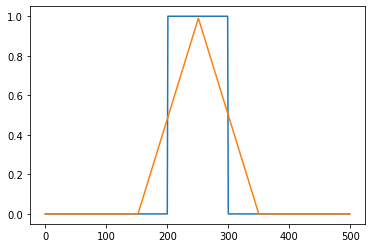

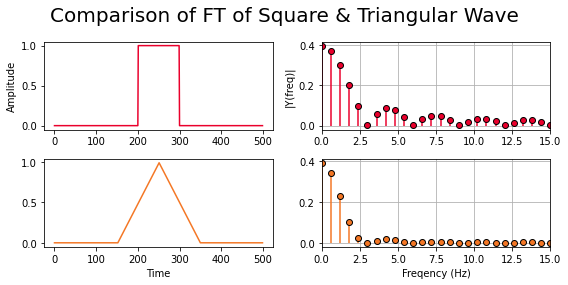

In [644]:
sample_rate = 100
num_samples = 500
wave = np.fromfunction(lambda i: (2*sample_rate < i) & (i < 3*sample_rate), (num_samples,)).astype('float')
wave1 = np.convolve(wave, wave, mode='same')/sample_rate
plt.plot(np.stack((wave, wave1), axis=1))
plt.show()

fig, ax = plt.subplots(2, 2, figsize=(8,4))
ax[0][0].plot(wave, sk_red)
ax[1][0].plot(wave1, sk_orange)
plot_fft(0,1,wave, sk_red, 300)
plot_fft(1,1,wave1, sk_orange, 300)
ax[1][0].set_xlabel('Time')
ax[0][0].set_ylabel('Amplitude')
ax[0][1].set_ylabel('|Y(freq)|')
ax[1][1].set_xlabel('Freqency (Hz)')
fig.suptitle("Comparison of FT of Square & Triangular Wave", fontsize=20)
plt.tight_layout()
plt.show()

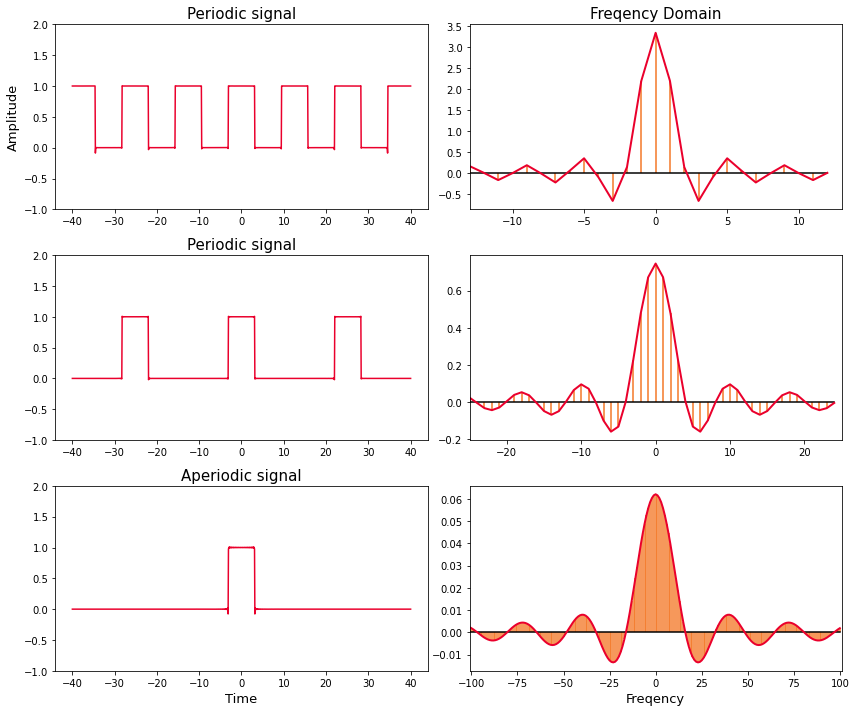

In [656]:
from scipy.signal import hilbert # envelope을 위한 패키지

# 사각파
def square_wave(t, timeDomain):
    T = t*np.pi
    f = 0
    num = 2000
    for n in range(-num, num):
        if n == 0:
            continue
        w = (n*2*np.pi)/T
        cn = np.sin((2*np.pi*n*np.pi)/T) /  (n*np.pi)
        f += cn*np.exp(1j*w*timeDomain)
    err = -np.mean(f[f < 0])
    f += err
    return f

# Fourier 변환
def fourier(t, timeDomain, f):
    T = t*np.pi
    cn = 0
    Fc = []
    Rs = round(T)
    nvec = np.arange(-Rs, Rs)
    for n in nvec:
        for i in range(len(timeDomain)-1):
            dt = timeDomain[i+1] - timeDomain[i]
            w = (2*np.pi*n)/T
            cn += f[i]*np.exp(-1j*w*timeDomain[i]) * dt
        Fc.append((1/T)*cn)
        cn = 0
    return nvec, Fc

tRange = 40
sampling_rate = 1000
timeDomain = np.linspace(-tRange, tRange, sampling_rate)

fig, ax = plt.subplots(3,2,figsize=(12, 10))

for i, t in enumerate([4, 8, 32]):
    # 사각파 plot
    f = square_wave(t, timeDomain)
    ax[i][0].plot(timeDomain, np.real(f), color=sk_red)
    ax[i][0].set_ylim(-1, 2)
    
    # Fourier transform plot
    nvec, Fc = fourier(t, timeDomain, f)
    y = hilbert(np.real(Fc)).real
    
    markers, stemlines, baseline = ax[i][1].stem(nvec, np.real(Fc))
    stemlines.set_color(sk_orange)
    markers.set_visible(False)
    baseline.set_color('k')
    ax[i][1].set_xlim(-np.fix(len(nvec)/2), np.fix(len(nvec)/2))
    ax[i][1].plot(nvec, y, linewidth=2, color=sk_red)

ax[0][0].set_title("Periodic signal", fontsize=15)
ax[1][0].set_title("Periodic signal", fontsize=15)
ax[2][0].set_title("Aperiodic signal", fontsize=15)
ax[0][1].set_title("Freqency Domain", fontsize=15)
ax[0][0].set_ylabel("Amplitude", fontsize=13)
ax[2][0].set_xlabel("Time", fontsize=13)
ax[2][1].set_xlabel("Freqency", fontsize=13)

plt.tight_layout()
plt.show()